<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/niko_code/model_building_nikodemas_find_model_with_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [19]:
!pip install category_encoders
!pip install skorch
!pip install shap
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.1 MB/s eta 0:00:00


# Imports

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import shap
import category_encoders as ce
import time

import skorch
import optuna

import numpy as np
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from skorch import NeuralNetRegressor
import optuna
from copy import deepcopy


# Data Imports and Processing


In [21]:
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/bandgap_dataset_premium.csv')

# Quick check
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  material_id  band_gap  formula   density       volume          a          b  \
0    mp-11107    3.5226    Ac2O3  9.109130    91.511224   4.095487   4.095489   
1    mp-32800    2.2962    Ac2S3  6.535149  1118.407852  14.997851  14.997851   
2   mp-977351    3.0275    Ac2S3  5.562971   328.464893   7.619779   7.619773   
3   mp-867311    0.0794  AcAgTe2  7.997421   122.518406   5.574922   5.574922   
4  mp-1183115    4.1024   AcAlO3  8.728230    57.451413   3.858634   3.858634   

           c       alpha        beta  ...      std_am  avg_vdw  vdw_range  \
0   6.299882   90.000000   90.000000  ...  103.368761    1.900       0.95   
1  14.997851  144.742139  144.742139  ...   95.498257    2.068       0.67   
2   7.875664  118.930903   61.069136  ...   95.498257    2.068       0.67   
3   5.574922   60.000000   60.000000  ...   46.591170    2.175       0.41   

In [22]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [23]:
# To test script: load dummy data

#from sklearn.datasets import fetch_openml

# Load a regression dataset from OpenML
#data = fetch_openml(name="house_prices", as_frame=True)  # Ames housing data
#df = data.frame

# Rename target to match our script
#df = df.rename(columns={"SalePrice": "band_gap"})

In [24]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [25]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (82998, 40)
Missing values per column:
formula: 1
avg_en: 9
max_en: 9
min_en: 9
std_en: 9
vbm: 876
cbm: 876
bulk_modulus: 79092
shear_modulus: 79092


,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm
count,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,...,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82122.000000,82122.000000
mean,1.984421,4.061805,668.913474,7.669236,8.044636,11.280915,86.028830,88.065828,89.700249,42.406058,...,110.699981,17.901714,31.772083,1.769480,0.787753,2.316020,1.528267,0.290510,1.585835,3.591381
std,1.560981,1.717274,693.624420,3.177138,2.800604,6.822619,17.420383,15.977789,22.074143,40.632079,...,57.428377,18.988597,20.400828,0.193034,0.380579,0.355453,0.203977,0.132925,2.238984,2.214685
min,0.000000,0.020144,11.286588,2.363000,2.363000,2.395898,3.664087,5.397478,5.397478,1.000000,...,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000,-14.222600,-7.360600
25%,0.653400,2.913572,254.760639,5.553544,6.015389,7.389807,77.756958,88.952439,86.976837,16.000000,...,55.845000,6.941000,15.265807,1.666000,0.540000,2.070000,1.520000,0.207338,0.166850,2.368150
50%,1.728450,3.773981,452.574159,7.012094,7.718989,9.712402,90.000000,90.000000,90.000000,29.000000,...,106.420000,15.999400,26.508649,1.729333,0.720000,2.230000,1.520000,0.267822,1.629350,3.660450
75%,3.013225,4.954535,841.664286,8.965331,9.328646,13.157808,90.000000,90.000000,99.717832,54.000000,...,151.964000,15.999400,45.960918,1.855000,0.970000,2.430000,1.520000,0.348872,2.952475,4.974900
max,17.891400,18.889325,20090.906408,46.210701,61.125585,211.425839,169.783994,169.783994,168.048246,444.000000,...,244.000000,227.000000,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000,12.376100,14.341400


In [26]:
# Drop columns that are prohibited

df = df.drop(columns='vbm')
df = df.drop(columns='cbm')
df = df.drop(columns='formula')
df = df.drop(columns='material_id')

# Band Gap Range

In [27]:
# Specify your band gap values
# df_subset = df[(df['band_gap'] >= 0.001) & (df['band_gap'] <= 5)]
min_band_gap = 0.001
max_band_gap = 50
df_subset = df[(df['band_gap'] >= min_band_gap) & (df['band_gap'] <= max_band_gap)]
display(df_subset.describe())

,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,...,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000,81998.000000
mean,2.008621,4.033431,672.461985,7.684102,8.062514,11.301802,86.022149,88.083887,89.751261,42.681004,...,3.015456,41.806994,110.408409,17.531845,31.728694,1.767303,0.792940,2.317925,1.524985,0.292209
std,1.554917,1.674945,694.552196,3.176485,2.790923,6.802653,17.335792,15.883331,22.025312,40.714649,...,1.026880,27.205139,57.213171,18.062631,20.351142,0.191568,0.379161,0.356644,0.200925,0.132420
min,0.001000,0.020144,11.286588,2.363000,2.363000,2.395898,5.200300,5.397478,5.397478,1.000000,...,0.000000,1.007940,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000
25%,0.688100,2.909166,257.364387,5.564078,6.028705,7.420564,77.817055,88.983131,87.252454,16.000000,...,2.416645,22.943680,55.845000,6.941000,15.278718,1.665500,0.540000,2.070000,1.520000,0.209335
50%,1.754650,3.756501,456.001697,7.028730,7.739968,9.731572,90.000000,90.000000,90.000000,30.000000,...,3.116394,31.789136,102.905500,15.999400,26.416604,1.728373,0.750000,2.230000,1.520000,0.268755
75%,3.031600,4.921850,845.734409,8.975985,9.344012,13.179710,90.000000,90.000000,99.687205,54.000000,...,3.607667,52.994662,150.360000,15.999400,45.925766,1.851395,0.970000,2.430000,1.520000,0.350143
max,17.891400,16.321559,20090.906408,46.210701,56.617301,211.425839,169.783994,169.783994,168.048246,444.000000,...,6.764457,218.862254,244.000000,208.980400,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000


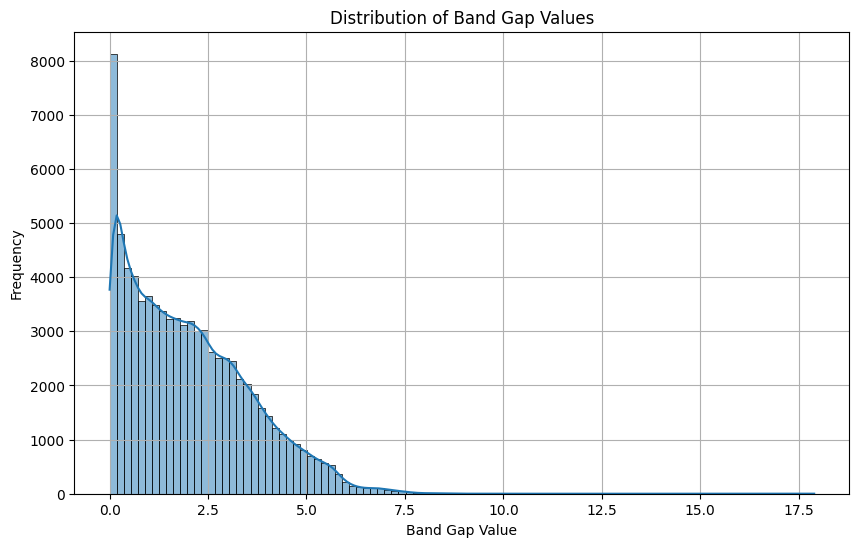

In [28]:
# Make a plot of band gap values based on occurences
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['band_gap'], bins=100, kde=True)
plt.title('Distribution of Band Gap Values')
plt.xlabel('Band Gap Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Define features and target

In [31]:
target_column = "band_gap"
X = df_subset.drop(columns=[target_column])
y = df_subset[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing

In [32]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df_subset.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df_subset = df_subset.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features


# Split into train and test sets BEFORE preprocessing
X = df_subset.drop("band_gap", axis=1)   # Replace "target" with your actual target column name
y = df_subset["band_gap"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Target Encoding on training set only
# Convert a meaningufl categorical feature into a numerical one. This is more dense that one-hot encoding
# Transform a categorical variable into a numerical one using the mean of the target variable for each category
te_col = "spacegroup_number "
te_encoder = ce.TargetEncoder(cols=[te_col])
# apply target encoding on training set
X_train[te_col] = te_encoder.fit_transform(X_train[te_col], y_train)

# apply target encoding on test set
X_test[te_col] = te_encoder.transform(X_test[te_col])


# Proceed with rest of pre-processing pipeline
# Separate numeric and categorical columns again after dropping columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Numeric features are imputed with the mean and then scaled
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), # fill missing values with mean
    StandardScaler()
)
# Categorical features are imputed with the most frequent value and then one-hot encoded
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # fill missing values with most frequent value
    OneHotEncoder(handle_unknown="ignore") # one-hot encode categorical features
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit and transform the training data, and transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Dropping columns with >65% missing values:
['bulk_modulus', 'shear_modulus']


In [33]:
# --- Determine input dimension after fitting preprocessor ---
preprocessor.fit(X_train)
input_dim = preprocessor.transform(X_train.iloc[[0]]).shape[1]

# Search for best Hyperparameters on the 8-layer model using Optuna

In [36]:
# Define the 8-layer neural network model

# --- Define your model ---
class DeepRegressor(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=384, hidden3=256, hidden4=192,
                 hidden5=128, hidden6=96, hidden7=64, hidden8=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(hidden3, hidden4),
            nn.ReLU(),

            nn.Linear(hidden4, hidden5),
            nn.ReLU(),

            nn.Linear(hidden5, hidden6),
            nn.ReLU(),

            nn.Linear(hidden6, hidden7),
            nn.ReLU(),

            nn.Linear(hidden7, hidden8),
            nn.ReLU(),

            nn.Linear(hidden8, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Wrap in Skorch and force float32 ---
class Float32Net(NeuralNetRegressor):
    def get_dataset(self, X, y=None):
        X = X.astype(np.float32)
        if y is not None:
            y = y.to_numpy().astype(np.float32).reshape(-1, 1)
        return super().get_dataset(X, y)

# --- Preprocessing pipeline ---
# numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# numeric_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy="mean")),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy="most_frequent")),
#     ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
# ])

# preprocessor = ColumnTransformer([
#     ("num", numeric_transformer, numeric_cols),
#     ("cat", categorical_transformer, categorical_cols)
# ])


# --- Optuna objective function ---
def objective(trial):
    # Hyperparameter search space
    params = {
        "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "hidden1": trial.suggest_int("hidden1", 512, 768, step=128),
        "hidden2": trial.suggest_int("hidden2", 384, 512, step=64),
        "hidden3": trial.suggest_int("hidden3", 256, 384, step=64),
        "hidden4": trial.suggest_int("hidden4", 192, 256, step=64),
        "hidden5": trial.suggest_int("hidden5", 128, 192, step=64),
        "hidden6": trial.suggest_int("hidden6", 96, 128, step=32),
        "hidden7": trial.suggest_int("hidden7", 64, 96, step=32),
        "hidden8": trial.suggest_int("hidden8", 32, 64, step=32),
    }

    net = Float32Net(
        module=DeepRegressor,
        module__input_dim=input_dim,
        module__hidden1=params["hidden1"],
        module__hidden2=params["hidden2"],
        module__hidden3=params["hidden3"],
        module__hidden4=params["hidden4"],
        module__hidden5=params["hidden5"],
        module__hidden6=params["hidden6"],
        module__hidden7=params["hidden7"],
        module__hidden8=params["hidden8"],
        max_epochs=50,
        lr=params["lr"],
        batch_size=params["batch_size"],
        optimizer=torch.optim.Adam,
        criterion=nn.MSELoss,
        train_split=None,
        verbose=0,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )

    pipeline = Pipeline([
        ("preprocessor", deepcopy(preprocessor)),
        ("regressor", net)
    ])

    # Split a hold-out validation set from training data
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)

    pipeline.fit(X_train_sub, y_train_sub)
    y_pred = pipeline.predict(X_val)
    return mean_absolute_error(y_val, y_pred)

# --- Run Optuna study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# --- Report best results ---
print("✅ Best MAE:", study.best_value)
print("🏆 Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-05-24 10:54:10,302] A new study created in memory with name: no-name-1176db1e-841f-47c7-abfa-23f1e7f723e0
<ipython-input-36-cc5314514390>:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
[I 2025-05-24 10:58:54,779] Trial 0 finished with value: 0.9081057249183551 and parameters: {'lr': 0.001575698497032403, 'batch_size': 32, 'hidden1': 512, 'hidden2': 384, 'hidden3': 384, 'hidden4': 256, 'hidden5': 192, 'hidden6': 96, 'hidden7': 96, 'hidden8': 32}. Best is trial 0 with value: 0.9081057249183551.
<ipython-input-36-cc5314514390>:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_loguniform("lr", 

✅ Best MAE: 0.7835026778498434
🏆 Best Hyperparameters:
  lr: 0.0003526210802543434
  batch_size: 64
  hidden1: 768
  hidden2: 448
  hidden3: 256
  hidden4: 192
  hidden5: 192
  hidden6: 128
  hidden7: 96
  hidden8: 32


## Save best model

In [41]:
import os
import json
import joblib
from datetime import datetime

# --- Specify model name ---
model_name = "deepregressor_8layer"

# --- Create a folder in Google Drive ---
folder_path = "/content/drive/MyDrive/machine_learning/best_optuna_results"
os.makedirs(folder_path, exist_ok=True)

# --- Timestamp (optional) ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Filenames ---
json_path = f"{folder_path}/{model_name}_results_{timestamp}.json"
pkl_path = f"{folder_path}/{model_name}_study_{timestamp}.pkl"
csv_path = f"{folder_path}/{model_name}_trials_{timestamp}.csv"

# --- Save best results as JSON ---
best_results = {
    "model": model_name,
    "timestamp": timestamp,
    "best_mae": study.best_value,
    "best_params": study.best_params
}
with open(json_path, "w") as f:
    json.dump(best_results, f, indent=4)
print(f"✅ Best results saved to: {json_path}")

✅ Best results saved to: /content/drive/MyDrive/machine_learning/best_optuna_results/deepregressor_8layer_results_20250524_123459.json


## Evaluate best model on test set

In [37]:
# 1. Extract the best hyperparameters
best_params = study.best_params

best_model = Float32Net(
        module=DeepRegressor,
        module__input_dim=input_dim,
        module__hidden1=best_params["hidden1"],
        module__hidden2=best_params["hidden2"],
        module__hidden3=best_params["hidden3"],
        module__hidden4=best_params["hidden4"],
        module__hidden5=best_params["hidden5"],
        module__hidden6=best_params["hidden6"],
        module__hidden7=best_params["hidden7"],
        module__hidden8=best_params["hidden8"],
        max_epochs=50,
        lr=best_params["lr"],
        batch_size=best_params["batch_size"],
        optimizer=torch.optim.Adam,
        criterion=nn.MSELoss,
        train_split=None,
        verbose=1,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )

# 3. Create pipeline with your existing preprocessor
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_model)
])

# 4. Fit on training data
final_pipeline.fit(X_train, y_train)

# 5. Predict on test data
y_pred = final_pipeline.predict(X_test)

# 6. Evaluate
from sklearn.metrics import mean_absolute_error, r2_score

print("\n📊 Test Performance of Best Model:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²:  {r2_score(y_test, y_pred):.4f}")

  epoch    train_loss     dur
-------  ------------  ------
      1        1.9354  3.8461
      2        1.6639  3.8130
      3        1.5770  3.8396
      4        1.5160  3.9614
      5        1.4741  3.7562
      6        1.4419  3.7773
      7        1.4081  3.8449
      8        1.3815  3.8536
      9        1.3603  3.7790
     10        1.3309  3.9302
     11        1.3217  3.7883
     12        1.2991  3.7746
     13        1.2802  3.7954
     14        1.2649  3.8507
     15        1.2476  3.7591
     16        1.2338  3.8076
     17        1.2215  3.8134
     18        1.2036  3.7862
     19        1.1933  3.8048
     20        1.1799  3.8451
     21        1.1694  3.8504
     22        1.1575  3.8253
     23        1.1503  3.8743
     24        1.1360  3.8260
     25        1.1292  3.7832
     26        1.1149  3.8044
     27        1.1075  3.9765
     28        1.1016  3.8505
     29        1.0913  3.8042
     30        1.0772  3.8718
     31        1.0742  3.8476
     32   

# 10 layer network with batch and leaky

In [ ]:
# --- Define your 10-layer model ---
class DeepRegressor(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=384, hidden3=256, hidden4=192,
                 hidden5=128, hidden6=96, hidden7=64, hidden8=48, hidden9=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden2, hidden3),
            nn.BatchNorm1d(hidden3),
            nn.LeakyReLU(),
            nn.Dropout(0.15),

            nn.Linear(hidden3, hidden4),
            nn.BatchNorm1d(hidden4),
            nn.LeakyReLU(),

            nn.Linear(hidden4, hidden5),
            nn.BatchNorm1d(hidden5),
            nn.LeakyReLU(),

            nn.Linear(hidden5, hidden6),
            nn.LeakyReLU(),

            nn.Linear(hidden6, hidden7),
            nn.LeakyReLU(),

            nn.Linear(hidden7, hidden8),
            nn.LeakyReLU(),

            nn.Linear(hidden8, hidden9),
            nn.LeakyReLU(),

            nn.Linear(hidden9, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Skorch wrapper with float32 casting ---
# --- Wrap in Skorch and force float32 ---
class Float32Net(NeuralNetRegressor):
    def get_dataset(self, X, y=None):
        X = X.astype(np.float32)
        if y is not None:
            y = y.to_numpy().astype(np.float32).reshape(-1, 1)
        return super().get_dataset(X, y)

# --- Optuna objective function ---
def objective(trial):
    params = {
        "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "hidden1": trial.suggest_int("hidden1", 512, 768, step=128),
        "hidden2": trial.suggest_int("hidden2", 384, 512, step=64),
        "hidden3": trial.suggest_int("hidden3", 256, 384, step=64),
        "hidden4": trial.suggest_int("hidden4", 192, 256, step=64),
        "hidden5": trial.suggest_int("hidden5", 128, 192, step=64),
        "hidden6": trial.suggest_int("hidden6", 96, 128, step=32),
        "hidden7": trial.suggest_int("hidden7", 64, 96, step=32),
        "hidden8": trial.suggest_int("hidden8", 48, 64, step=16),
        "hidden9": trial.suggest_int("hidden9", 32, 48, step=16),
    }

    net = Float32Net(
        module=DeepRegressor,
        module__input_dim=input_dim,
        module__hidden1=params["hidden1"],
        module__hidden2=params["hidden2"],
        module__hidden3=params["hidden3"],
        module__hidden4=params["hidden4"],
        module__hidden5=params["hidden5"],
        module__hidden6=params["hidden6"],
        module__hidden7=params["hidden7"],
        module__hidden8=params["hidden8"],
        module__hidden9=params["hidden9"],
        max_epochs=50,
        lr=params["lr"],
        batch_size=params["batch_size"],
        optimizer=torch.optim.Adam,
        criterion=nn.MSELoss,
        train_split=None,
        verbose=0,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Build and fit pipeline
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),  # assuming your preprocessor is already defined
        ("regressor", net)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# --- Run Optuna study ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# --- Report best results ---
print("✅ Best MAE:", study.best_value)
print("🏆 Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


[I 2025-05-24 12:35:56,079] A new study created in memory with name: no-name-82dab541-9364-45b7-9d99-8e3ab5a7d181
<ipython-input-42-f947d07fbd54>:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_loguniform("lr", 1e-4, 1e-2),
[I 2025-05-24 12:40:03,852] Trial 0 finished with value: 0.782541231801526 and parameters: {'lr': 0.00010146997950502016, 'batch_size': 64, 'hidden1': 768, 'hidden2': 448, 'hidden3': 384, 'hidden4': 256, 'hidden5': 128, 'hidden6': 96, 'hidden7': 96, 'hidden8': 48, 'hidden9': 48}. Best is trial 0 with value: 0.782541231801526.
<ipython-input-42-f947d07fbd54>:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_lo

In [ ]:
import os
import json
import joblib
from datetime import datetime

# --- Specify model name ---
model_name = "deepregressor_10layer_batch_leaky"

# --- Create a folder in Google Drive ---
folder_path = "/content/drive/MyDrive/machine_learning/best_optuna_results"
os.makedirs(folder_path, exist_ok=True)

# --- Timestamp (optional) ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Filenames ---
json_path = f"{folder_path}/{model_name}_results_{timestamp}.json"
pkl_path = f"{folder_path}/{model_name}_study_{timestamp}.pkl"
csv_path = f"{folder_path}/{model_name}_trials_{timestamp}.csv"

# --- Save best results as JSON ---
best_results = {
    "model": model_name,
    "timestamp": timestamp,
    "best_mae": study.best_value,
    "best_params": study.best_params
}
with open(json_path, "w") as f:
    json.dump(best_results, f, indent=4)
print(f"✅ Best results saved to: {json_path}")

# Summary of all

# Using multiple tests to predict the best neural network configuration